In [1]:
import random
import torch
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.ops import box_iou
import matplotlib.patches as patches

In [2]:
class Transform:
    def __call__(self, img, target):
        return transforms.ToTensor()(img), transforms.ToTensor()(target)
    
transform = Transform()
dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transforms=transform)
random.seed(42)
n_images = 100
random_indices = random.sample(range(len(dataset)), n_images)
subset = torch.utils.data.Subset(dataset, random_indices)

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


In [3]:
print(len(subset))

100


In [4]:
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
model.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

def calculate_iou(pred_boxes, gt_boxes):
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0.0
    ious = box_iou(pred_boxes, gt_boxes)
    return ious.max(dim=1)[0].mean().item()

def mask_to_boxes(mask):
    obj_ids = torch.unique(mask)[1:]
    boxes = []
    for obj_id in obj_ids:
        pos = torch.nonzero(mask == obj_id, as_tuple=True)
        xmin, ymin, xmax, ymax = pos[1].min().item(), pos[0].min().item(), pos[1].max().item(), pos[0].max().item()
        boxes.append([xmin, ymin, xmax, ymax])
    return torch.tensor(boxes, dtype=torch.float32)

iou_scores = []

for img, target in subset:
    img = img.to(device)
    mask = target.squeeze(0)
    gt_boxes = mask_to_boxes(mask).to(device)
    with torch.no_grad():
        predictions = model([img])   
    pred_boxes = predictions[0]['boxes']
    iou = calculate_iou(pred_boxes, gt_boxes)
    iou_scores.append(iou)

average_iou = np.mean(iou_scores)
print("Az átlagos IoU: ", average_iou)

Az átlagos IoU:  0.2863016267120838


In [5]:
coco_classes = weights.meta['categories']
print(coco_classes)

['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [15]:
def visualize_predictions(images, predictions, coco_classes):
    fig, axs = plt.subplots(len(images), 1, figsize=(5, 20))
    for i, (img, prediction) in enumerate(zip(images, predictions)):
        img = img.permute(1, 2, 0).cpu().numpy()
        ax = axs[i]
        ax.imshow(img)
        ax.axis('off')
        for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
            if label >= len(coco_classes):
                continue
            if score < 0.5:
                continue
            box = box.cpu().numpy()
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            class_name = coco_classes[label]
            ax.text(
                xmin, ymin, f'{class_name} {score:.2f}',
                bbox=dict(facecolor='yellow', alpha=0.5), fontsize=8, color='black'
            )
    plt.tight_layout()
    plt.show()

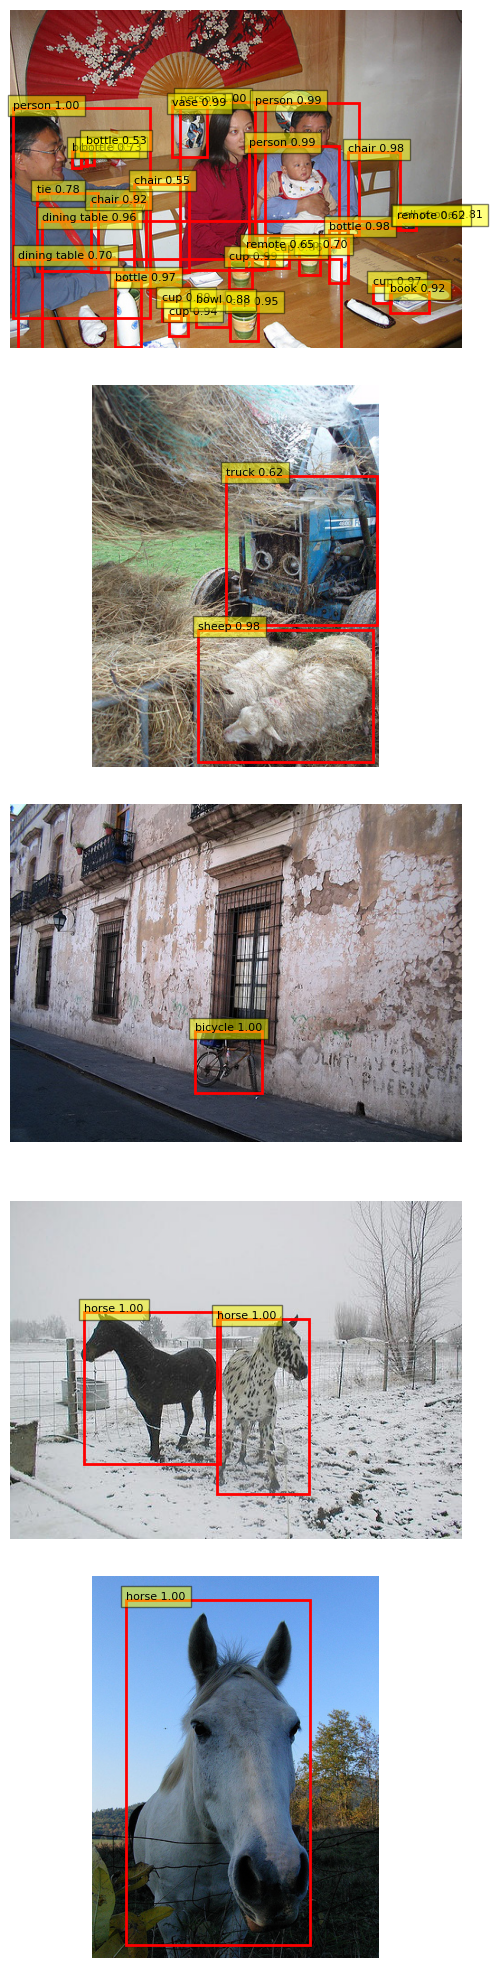

In [17]:
images_to_visualize = []
predictions_to_visualize = []
n_visualizations = min(5, len(subset))

for i in range(n_visualizations):
    img, _ = subset[i]
    img = img.to(device)
    with torch.no_grad():
        predictions = model([img])
    images_to_visualize.append(img.cpu())
    predictions_to_visualize.append(predictions[0])

visualize_predictions(images_to_visualize, predictions_to_visualize, coco_classes)